In [1]:
import numpy as np
from pysrc.optimization import gams, gurobi
from pysrc.sampling import baseline
from pysrc.services.data_service import load_site_data
from pysrc.analysis import value_decomposition

/Users/ph2696/Projects/project-amazon/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Model scenario

In [2]:
opt = "gurobi"
pee = 7.6
pa = 41.11
b = 25
sitenum = 1043
T = 200
h = 50

## Solve model

In [3]:
# Load site data
(
    zbar_2017,
    z_2017,
    forest_area_2017,
    _,
    _,
    _,
    _,
) = load_site_data(sitenum)

# Set productivity parameters using baseline mean
baseline_fit = baseline.sample(
    num_sites=sitenum,
    iter_sampling=10**4,
    chains=5,
    seed=1,
)

theta = baseline_fit.stan_variable("theta").mean(axis=0)
gamma = baseline_fit.stan_variable("gamma").mean(axis=0)

# Computing carbon absorbed in start period
x0_vals = gamma * forest_area_2017

# Choose optimizer
if opt == "gurobi":
    solve_planner_problem = gurobi.solve_planner_problem

elif opt == "gams":
    solve_planner_problem = gams.solve_planner_problem

else:
    raise ValueError("Optimizer must be one of ['gurobi', 'gams']")

results = solve_planner_problem(
    T=T + h,
    theta=theta,
    gamma=gamma,
    x0=x0_vals,
    zbar=zbar_2017,
    z0=z_2017,
    pe=pee + b,
    pa=pa,
)

Data successfully loaded from /Users/ph2696/Projects/project-amazon/data/calibration/hmc


12:16:40 - cmdstanpy - INFO - compiling stan file /Users/ph2696/Projects/project-amazon/stan_model/baseline.stan to exe file /Users/ph2696/Projects/project-amazon/stan_model/baseline


Data successfully loaded from /Users/ph2696/Projects/project-amazon/data/calibration/hmc


12:16:44 - cmdstanpy - INFO - compiled model executable: /Users/ph2696/Projects/project-amazon/stan_model/baseline
12:16:49 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status






chain 1 |          | 00:00 Status




chain 1 |▏         | 00:01 Iteration:    1 / 10000 [  0%]  (Sampling)





chain 1 |▎         | 00:01 Iteration:  100 / 10000 [  1%]  (Sampling)






chain 1 |▎         | 00:02 Iteration:  200 / 10000 [  2%]  (Sampling)








chain 1 |▍         | 00:02 Iteration:  300 / 10000 [  3%]  (Sampling)





chain 1 |▌         | 00:03 Iteration:  400 / 10000 [  4%]  (Sampling)





chain 1 |▋         | 00:03 Iteration:  500 / 10000 [  5%]  (Sampling)







chain 1 |▋         | 00:04 Iteration:  600 / 10000 [  6%]  (Sampling)



chain 1 |▊         | 00:04 Iteration:  700 / 10000 [  7%]  (Sampling)





chain 1 |▉         | 00:05 Iteration:  800 / 10000 [  8%]  (Sampling)





chain 1 |▉         | 00:05 Iteration:  900 / 10000 [  9%]  (Sampling)






12:17:43 - cmdstanpy - INFO - CmdStan done processing.



Solving the optimization problem...
Set parameter Username
Academic license - for non-commercial use only - expires 2024-10-30
Read LP format model from file /var/folders/d1/k6sr3htd7fdgk614mmq8pwq00000gr/T/tmp82bhbzcy.pyomo.lp
Reading time = 1.30 seconds
x1: 521750 rows, 1043251 columns, 2604621 nonzeros
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[arm])

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 521750 rows, 1043251 columns and 2604621 nonzeros
Model fingerprint: 0xaca4dae2
Model has 250 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+03]
  Objective range  [5e-04, 6e+03]
  QObjective range [1e+03, 2e+05]
  Bounds range     [3e-06, 1e+00]
  RHS range        [9e-11, 5e-01]
Presolve removed 261097 rows and 261444 columns
Presolve time: 0.38s
Presolved: 260653 rows, 781807 columns, 1562320 nonzeros
Presolved model has 250 quadratic objective terms
Ordering time: 0.02s

In [4]:
results["w"].shape

(251,)

In [5]:
value_decomposition(
    Z=results["Z"],
    X=results["X"],
    U=results["U"],
    V=results["V"],
    T=T+h,
    pee=pee,
    pa=pa,
    b=b,
    theta=theta,
)

{'pa': 41.11,
 'pee': 7.6,
 'b': 25,
 'total_AO': 18.689050526190634,
 'total_NT': 350.9249948421031,
 'total_FS': 106.68119843199933,
 'total_AC': 26.627797122943626,
 'total_PV': 449.66744667734946}

In [6]:
V = [
    value_decomposition(
        Z=results["Z"][t:],
        X=results["X"][t:],
        U=results["U"][t:],
        V=results["V"][t:],
        T=T,
        pee=pee,
        pa=pa,
        b=b,
        theta=theta,
    )["total_PV"]
    for t in range(h)
]

<function matplotlib.pyplot.show(close=None, block=None)>

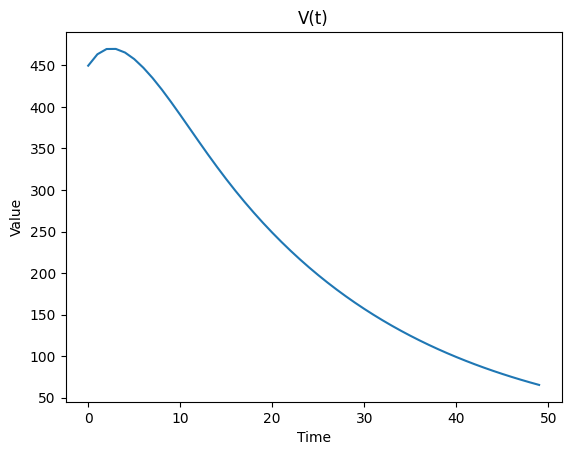

In [7]:
import matplotlib.pyplot as plt

# Plotting the line plot
plt.plot(V)

# Adding labels and title
plt.xlabel("Time")
plt.ylabel("Value")
plt.title("V(t)")

# Displaying the plot
plt.show

In [8]:
W = []
for t in range(h):
    defection = solve_planner_problem(
        T=T,
        theta=theta,
        gamma=gamma,
        x0=results["X"][t],
        zbar=zbar_2017,
        z0=results["Z"][t],
        pe=pee,
        pa=pa,
    )

    W.append(
        value_decomposition(
            Z=defection["Z"],
            X=defection["X"],
            U=defection["U"],
            V=defection["V"],
            T=T,
            pee=pee,
            pa=pa,
            b=0,
            theta=theta,
        )["total_PV"]
    )

Solving the optimization problem...
Set parameter Username
Academic license - for non-commercial use only - expires 2024-10-30
Read LP format model from file /var/folders/d1/k6sr3htd7fdgk614mmq8pwq00000gr/T/tmpeardv037.pyomo.lp
Reading time = 1.05 seconds
x1: 417400 rows, 834601 columns, 2083071 nonzeros
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[arm])

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 417400 rows, 834601 columns and 2083071 nonzeros
Model fingerprint: 0x8154808b
Model has 200 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+03]
  Objective range  [8e-04, 1e+03]
  QObjective range [3e+03, 2e+05]
  Bounds range     [3e-06, 1e+00]
  RHS range        [9e-11, 5e-01]
Presolve removed 208947 rows and 209294 columns
Presolve time: 0.30s
Presolved: 208453 rows, 625307 columns, 1249370 nonzeros
Presolved model has 200 quadratic objective terms
Ordering time: 0.01s

B

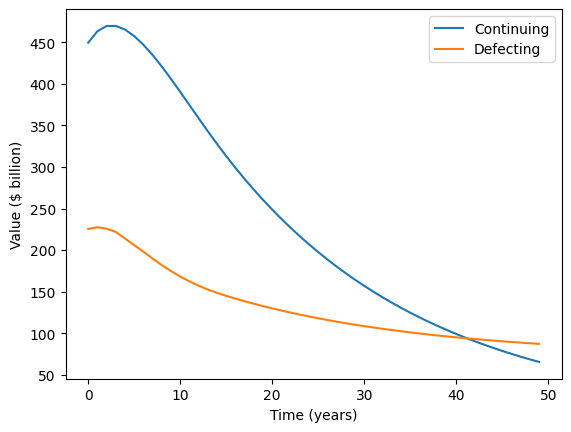

In [9]:
# Plotting the line plots for V and W
plt.plot(V, label="Continuing")
plt.plot(W, label="Defecting")

# Adding legend
plt.legend()

# Adding labels and title
plt.xlabel("Time (years)")
plt.ylabel("Value ($ billion)")
#plt.title("Value under b=$25 scheme v.s defecting")

# Displaying the plot
plt.show()

## Time and value of defecting

In [10]:
def defect_time(V, W):
    indices = [i for i, (v, w) in enumerate(zip(V, W)) if v < w]
    return indices[0] if indices else -1

In [11]:
defect_time(V, W)

42

## Maximum gap between $V(t)$ and $W(t)$

In [12]:
abs(min([V[i] - W[i] for i in range(h)]))

21.72619259611055

In [13]:
abs(min([V[i] - W[i] for i in range(h)])) / (1.02 ** (h))

8.071886321915425

In [14]:
[(V[i] - W[i])/ (1.02 ** i) for i in range(h)]

[224.24201806877255,
 231.2590077988053,
 234.49494774764165,
 233.64690807473445,
 232.40282706822995,
 227.98968318697865,
 221.1438200944244,
 213.24042770050053,
 204.02800259459707,
 193.47574005404246,
 182.3165163960284,
 170.68873570190178,
 158.9306607516302,
 147.19462200242342,
 135.82971688415998,
 124.96966295199121,
 114.68175549328402,
 105.06176283033786,
 96.1001927219786,
 87.75419357483618,
 79.98366226752084,
 72.75106864131932,
 66.02129118328126,
 59.76146318824232,
 53.94082873180405,
 48.53060782886455,
 43.50387019215646,
 38.835417042566505,
 34.50167045796179,
 30.48056977994495,
 26.751474628615213,
 23.2950741040679,
 20.093301780228053,
 17.129256121750018,
 14.387125978246768,
 11.852120832157246,
 9.510405497184385,
 7.349038983559988,
 5.355917264473313,
 3.5197196949364566,
 1.8298588502135045,
 0.27643356578206835,
 -1.1498150253031234,
 -2.4575446487699635,
 -3.6548504181454895,
 -4.749300903964954,
 -5.747971900026654,
 -6.657478033547787,
 -7.48400

## Analysing gap

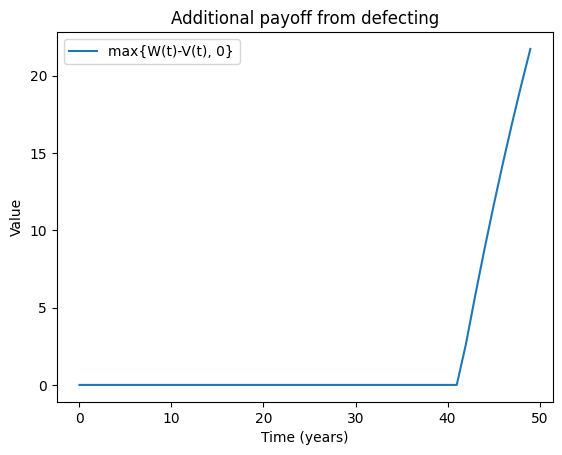

In [15]:
gap = [max(W[i] - V[i], 0) for i in range(h)]

# Plotting the line plots for V and W
plt.plot(gap, label="max{W(t)-V(t), 0}")

# Adding legend
plt.legend()

# Adding labels and title
plt.xlabel("Time (years)")
plt.ylabel("Value")
plt.title("Additional payoff from defecting")

# Displaying the plot
plt.show()

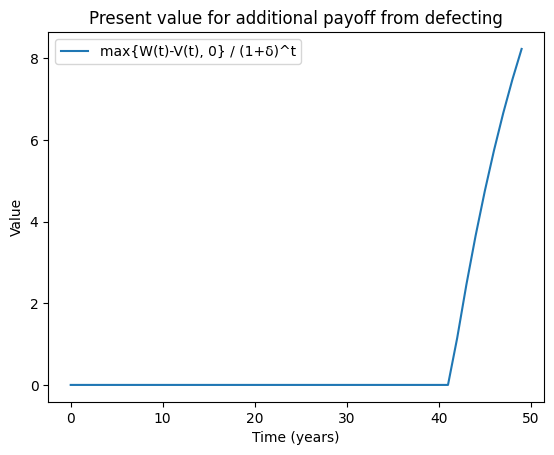

In [16]:
PV_gap = [max(W[t] - V[t], 0) / (1.02 ** (t)) for t in range(h)]

# Plotting the line plots for V and W
plt.plot(PV_gap, label="max{W(t)-V(t), 0} / (1+δ)^t")

# Adding legend
plt.legend()

# Adding labels and title
plt.xlabel("Time (years)")
plt.ylabel("Value")
plt.title("Present value for additional payoff from defecting")

# Displaying the plot
plt.show()

In [17]:
PV_gap[49]

8.233324048353733

In [18]:
V[0]

449.66630046250356

In [20]:
W[49]

87.15098470960368

In [24]:
results["Z"][49].sum() / zbar_2017.sum()

2.5561771364885074e-13